In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp

In [2]:
def take_only_walkers_on_fibre_trajectory(in_file, out_file=None):
    """Takes an input file or a stack in the form of TYXC and saves it to out file. Writes the shape of TYX"""  # I changed this to TYXC. My input has a different shape

    if isinstance(in_file, str):
        # Could also be a path object, but that would now fail. pethaps change to file exists, or test if in_file is an array
        stack = skio.imread(in_file)
    else:
        stack = in_file

    dims = stack.shape
    print(dims)
    # skip the channel?
    new_dims = (dims[0], dims[1], dims[2])
    out = np.zeros(new_dims, dtype=np.uint8)
    for i in range(dims[0]):
        frame_fibre = stack[i, :, :, 2]
        frame_walker = stack[i, :, :, 0]
        new = take_only_walkers_on_fibre(frame_fibre, frame_walker)
        out[i] = new

    tifffile.imwrite(
        out_file,
        out,
        ome=True,
        dtype=np.uint8,
        photometric="minisblack",
        metadata={"axes": "TYX"},
    )

In [15]:
in_path = "data/05022024_1a8_2b11_0.5nM/out/"
in_filename = ""
out_path = "out"    

In [ ]:
in_file = Path(in_path).joinpath(in_filename)
basename = os.path.basename(in_file)
out_dir = Path(in_path).joinpath("out")
os.makedirs(out_dir, exist_ok=True)

if in_filename=="":
    iterate_over_folder=True

take_only_walkers_on_fibre_trajectory(in_file.__str__(), out_dir / basename)
basename_noext, ext = os.path.splitext(basename)

AttributeError: 'function' object has no attribute 'shape'

In [5]:
fit_method = "lq"
box_side_length = 5
drift = 0
min_gradient = 600

In [6]:
#os.environ['HDF5_DISABLE_VERSION_CHECK']='0'
#TOOD add out parameter
!python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift}



    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           out\20240205-141407_WT_dober_aligned_drift_corrected.tif
3        box_side_length 5         
4        fit_method      lq        
5        gradient        600       
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='local


LQ fitting: 100%|██████████| 1200/1200 [00:16<00:00, 71.89task/s] 


In [7]:
# Hack -- for now just rename the out file. This is dangerous in multithreaded environment.
out_locs = out_dir / (basename_noext + "_locs.hdf5")
new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
new_suffix = (
    f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
)
new_out_locs = out_dir / (basename_noext + new_suffix)
print(new_out_locs)
out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
out_locs.rename(new_out_locs)

out\20240205-141407_WT_dober_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5


WindowsPath('out/20240205-141407_WT_dober_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5')

In [8]:
max_link_displacement_px = 2
min_tray_length = 3

In [9]:
new_out_locs

WindowsPath('out/20240205-141407_WT_dober_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5')

Frame 3669: 6 trajectories present.
mean drift  y   -8.081163
x    0.003676
dtype: float32
2340
Diff:  0.1376273697333945
NOT NORMAL AT 10.0%
Diff (in px^2/frame):  0.1376352459192276
Diff (in nm^2/s):  2504.340564846096
time per 1000nm (s):  199.6533566634646
mean step (nm/s): 86.78623924819765


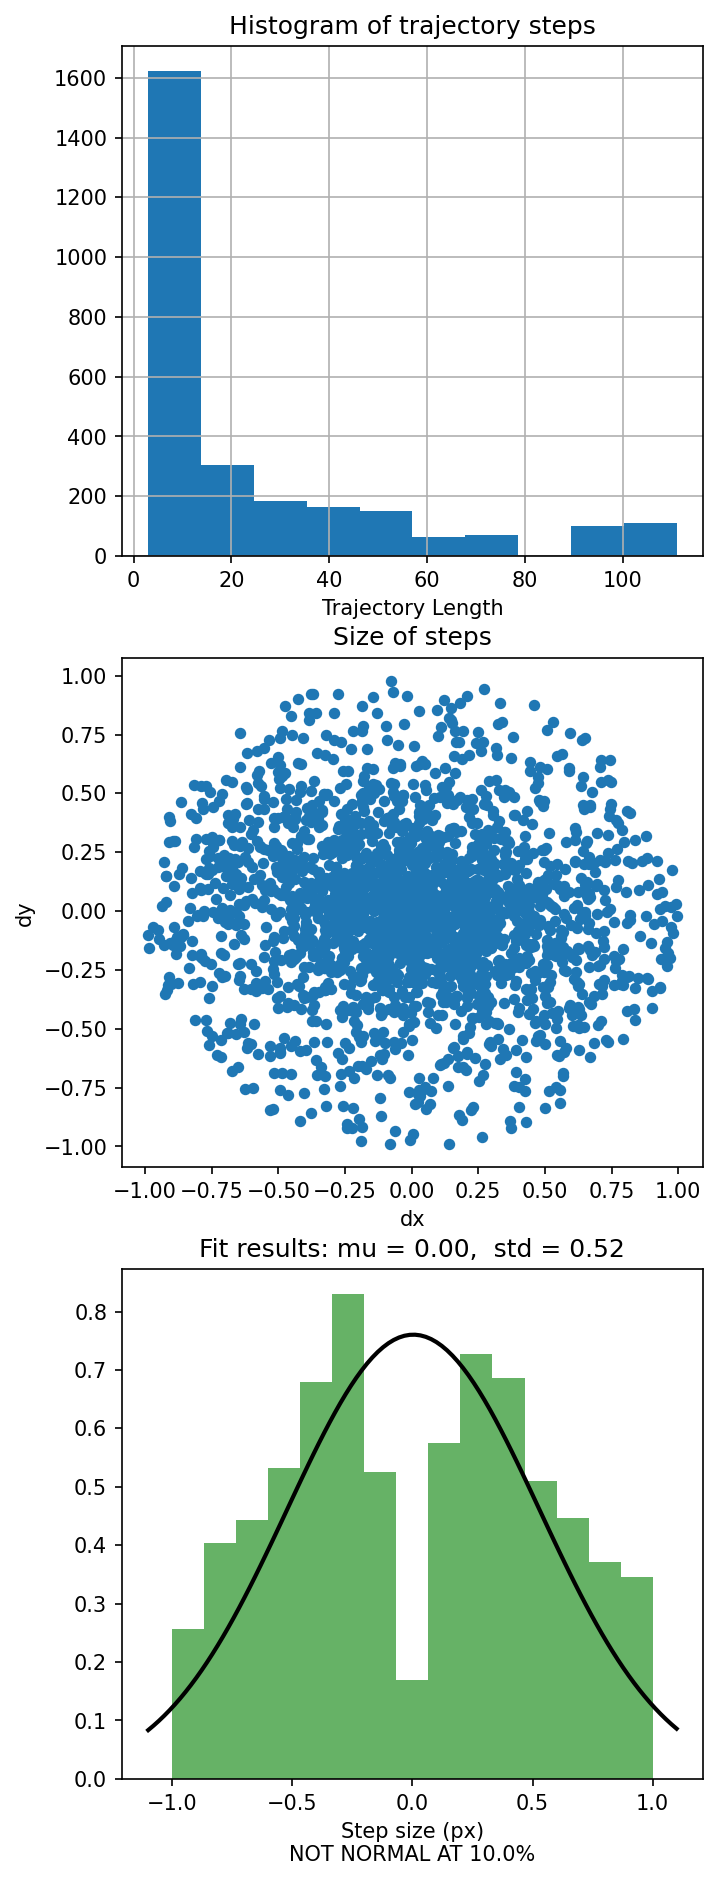

In [11]:
for max_link_displacement_px in [1]:
    locs = pd.read_hdf(new_out_locs, "locs")
    locs["mass"] = locs.photons

    tray = tp.link(locs, max_link_displacement_px)

    # count the length of trajectories
    tray_by_particle = tray.groupby(["particle"])
    tray["length"] = tray_by_particle["particle"].transform("count")

    # tray.length.hist()
    print("mean drift ", tp.compute_drift(tray).mean())

    # Exclude very short trays
    tray = tray.query(f"length>={min_tray_length}")

    steps = tray.groupby(["particle"]).apply(get_steps_from_df)
    steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)
    print(len(steps))

    suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
    base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
    tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
    tray.to_csv(tray_out)
    steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
    steps.to_csv(steps_out)

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

    plt.sca(axes[0])
    tray.length.hist()
    plt.xlabel("Trajectory Length")
    plt.title("Histogram of trajectory steps")

    plt.sca(axes[1])
    steps.plot.scatter("dx", "dy", ax=axes[1])
    plt.title("Size of steps")

    plt.sca(axes[2])
    import numpy as np
    import scipy
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    step_len_signed = steps.step_len * np.random.choice((-1, 1), size=len(steps))
    # Generate some data for this demonstration.
    data = step_len_signed

    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)
    print("Diff: ", std**2 / 2)

    # Plot the histogram.
    plt.hist(data, bins=15, density=True, alpha=0.6, color="g")

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)

    plt.title(title)

    # perform Anderson-Darling Test
    from scipy.stats import anderson

    anderson_data = anderson(data)

    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    if not is_normal:
        normal_str = f"NOT NORMAL AT {anderson_data.significance_level[1]}%"
    else:
        normal_str = f"normal at {anderson_data.significance_level[1]}%"
    print(normal_str)
    plt.xlabel("Step size (px)\n" + normal_str)
    plt.savefig(base_linked_tray.with_suffix(".png"))

    info = {}
    info["diff_1D_px_px_frame"] = float(get_diff_from_steps(steps))
    print("Diff (in px^2/frame): ", info["diff_1D_px_px_frame"])

    px_to_nm = 110
    frame_to_s = 0.665

    info["diff_1D_nm_nm_s"] = (
        info["diff_1D_px_px_frame"] * px_to_nm * px_to_nm / frame_to_s
    )
    print("Diff (in nm^2/s): ", info["diff_1D_nm_nm_s"])
    info["time_per_1000nm_s"] = 1000 * 1000 / info["diff_1D_nm_nm_s"] / 2
    print("time per 1000nm (s): ", info["time_per_1000nm_s"])

    info["mean_step_nm_s"] = float(
        np.sqrt(2 * info["diff_1D_nm_nm_s"] * frame_to_s) / frame_to_s
    )
    print("mean step (nm/s):", info["mean_step_nm_s"])

    diff_info_out = base_linked_tray.with_suffix(".diff")

    info["normality_str"] = normal_str
    info["anderson_test"] = anderson_data

    write_yaml(info, diff_info_out)